In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from glob import glob

# Tricking your cerebellum with a reaching task
# Exercise 2 – Savings, generalization & interference

By: Robin Uhrich* and Ieva Kerseviciute*

*equal contribution

## Task 1: Implementation of recording mode and new experiment

### Savings - capturing a baseline

The experimental flow is as follows:

- 20 attempts without perturbation (0-20)
- 60 attempts with perturbation (20-80)
- 20 attempts without perturbation (80-100)
- 60 attempts with perturbation (100-160)
- 20 attempts without perturbation (160-180)

Perturbation of 30 degrees is performed.

This part does not include any additional implementations (task 4).

```{python}
...

PERTURBATION_ANGLE = 30

...

ATTEMPTS_LIMIT = 180

...
    # Design experiment
    if attempts == 1:
        perturbation_mode = False
    elif attempts == 20:
        perturbation_mode = True
        perturbation_type = "sudden"
    elif attempts == 80:
        perturbation_mode = False
    elif attempts == 100:
        perturbation_mode = True
        perturbation_type = "sudden"
    elif attempts == 160:
        perturbation_mode = False
    elif attempts >= ATTEMPTS_LIMIT:
        running = False
...
```

### Group A: Generalization

The experiment is performed in 5 blocks. Each block contains 3 stages, 100 attempts total:

- 20 attempts without perturbation
- 60 attempts with perturbation
- 20 attempts without perturbation

In each part, the target is shifted to a new location:

1. -15 degrees (30 degree perturbation)
2. -75 degrees (30 degree perturbation)
3. -45 degrees (30 degree perturbation)
4. -120 degrees (30 degree perturbation)
5. -120 degrees (-30 degree perturbation)

In this part, we include an additional experiment: the 5th block, in which the perturbation angle is reversed.

```{python}
...

# List the target starting angles here
TARGET_ANGLES = [-15, -75, (-75 - 15) / 2, -120]

PERTURBATION_ANGLE = 30

...

# Setup for blocks
n_perturbation = 60
n_no_perturbation = 20
block_len = n_no_perturbation + n_perturbation + n_no_perturbation

block1_start = 0
block2_start = block_len
block3_start = block_len * 2
block4_start = block_len * 3
block5_start = block_len * 4

ATTEMPTS_LIMIT = block_len * 5

...

    # Design experiment

    # A single block:
    #   - 20 attempts without perturbation
    #   - 60 attempts with perturbation
    #   - 20 attempts without perturbation

    # Block 1
    if attempts == block1_start:
        START_ANGLE = TARGET_ANGLES[0]
        start_target = math.radians(START_ANGLE)
        perturbation_mode = False
    elif attempts == block1_start + n_no_perturbation:
        perturbation_mode = True
        perturbation_type = "sudden"
    elif attempts == block1_start + n_no_perturbation + n_perturbation:
        perturbation_mode = False

    # Block 2
    elif attempts == block2_start:
        START_ANGLE = TARGET_ANGLES[1]
        start_target = math.radians(START_ANGLE)
        perturbation_mode = False
    elif attempts == block2_start + n_no_perturbation:
        perturbation_mode = True
        perturbation_type = "sudden"
    elif attempts == block2_start + n_no_perturbation + n_perturbation:
        perturbation_mode = False

    # Block 3
    elif attempts == block3_start:
        START_ANGLE = TARGET_ANGLES[2]
        start_target = math.radians(START_ANGLE)
        perturbation_mode = False
    elif attempts == block3_start + n_no_perturbation:
        perturbation_mode = True
        perturbation_type = "sudden"
    elif attempts == block3_start + n_no_perturbation + n_perturbation:
        perturbation_mode = False

    # Block 4
    elif attempts == block4_start:
        START_ANGLE = TARGET_ANGLES[3]
        start_target = math.radians(START_ANGLE)
        perturbation_mode = False
    elif attempts == block4_start + n_no_perturbation:
        perturbation_mode = True
        perturbation_type = "sudden"
    elif attempts == block4_start + n_no_perturbation + n_perturbation:
        perturbation_mode = False

    # Block 5: repeat block 4 with perturbation angle in the opposite direction
    if attempts == block5_start:
        START_ANGLE = TARGET_ANGLES[3]
        start_target = math.radians(START_ANGLE)
        perturbation_mode = False
    elif attempts == block5_start + n_no_perturbation:
        # Reverse perturbation angle
        perturbation_angle = -perturbation_angle
        perturbation_mode = True
        perturbation_type = "sudden"
    elif attempts == block5_start + n_no_perturbation + n_perturbation:
        perturbation_mode = False

    # End
    elif attempts >= ATTEMPTS_LIMIT:
        running = False

...
```

## Task 2: Analysis of experiment on unbiased subjects

### Savings

In [48]:
experiment = pd.DataFrame({
    "Attempt": [1, 20, 80, 100, 160],
    "AttemptEnd": np.array([20, 80, 100, 160, 180]) - 1,
    "Perturbation": [
        "No perturbation", "Sudden",
        "No perturbation", "Sudden",
        "No perturbation"
    ]
})

n_attempts = 180

attempts = list(range(1, n_attempts + 1))

perturbations = []
for i in range(len(experiment)):
    start = experiment["Attempt"][i]
    end = experiment["Attempt"][i + 1] if i + 1 < len(experiment) else n_attempts + 1
    perturbations.extend([experiment["Perturbation"][i]] * (end - start))

full_experiment = pd.DataFrame({ "Attempt": attempts, "Perturbation": perturbations })

In [49]:
def read_data(filename):
    res = np.load(filename, allow_pickle = True)
    return pd.DataFrame({
        "MoveFaster": res.item()["move_faster_logs"],
        "ErrorAngle": res.item()["error_angle_logs"],
        "Time": res.item()["time_logs"],
        "Attempt": np.arange(len(res.item()["move_faster_logs"])) + 1
    })


def preprocess(data, design):
    # Merge with experimental design describing perturbation conditions
    data = pd.merge(data, design)

    # Remove trials where move faster appeared
    data = data[data.MoveFaster == 0]
    data.reset_index(drop = True, inplace = True)

    return data


def evaluate_statistics(data):
    statistics = []

    for _, change in experiment.iterrows():
        selected_data = data[(data.Attempt >= change.Attempt) & (data.Attempt <= change.AttemptEnd)]
        error_angle = selected_data.ErrorAngle.to_numpy()
        error_angle = error_angle[~selected_data.MoveFaster.to_numpy().astype(bool)]

        statistics.append(pd.DataFrame({
            "Perturbation": change.Perturbation,
            "ErrorAngleStd": [error_angle.std()],
            "ErrorAngleMean": [error_angle.mean()],
            "TimeStd": [selected_data.Time.std()],
            "TimeMean": [selected_data.Time.mean()]
        }))

    statistics = pd.concat(statistics, ignore_index = True)

    return statistics

In [50]:
def plot_error_angle(subjects, experiment):
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

    color_map = mpl.colormaps["autumn"]
    n_colors = len(experiment.Perturbation.unique())
    colors = [color_map(idx / (n_colors - 1)) for idx in range(n_colors)]
    colors = dict(zip(experiment.Perturbation.unique(), colors))
    unique_periods = experiment.Perturbation.unique()

    # Show the different experimental periods
    for i, change in experiment.iterrows():
        label = change.Perturbation if change.Perturbation in unique_periods else ""
        unique_periods = unique_periods[unique_periods != change.Perturbation]

        start = change.Attempt
        end = change.AttemptEnd

        axs[0].axvspan(
            start, end,
            alpha = 0.2,
            label = label,
            color = colors.get(change.Perturbation)
        )

    for i, subject in enumerate(subjects):
        error_angle: np.ndarray = subject.ErrorAngle.to_numpy()
        error_angle[subject.MoveFaster.to_numpy().astype(bool)] = np.nan
        axs[0].plot(
            subject.Attempt,
            error_angle,
            linewidth = 1,
            label = f"Trial {i + 1}",
            alpha=0.4
        )

    axs[0].set_ylabel("Error angle (degrees)")
    axs[0].set_xlabel("Attempt")
    axs[0].legend(loc = "center left", bbox_to_anchor = (1, 0.5))
    axs[0].set_title("Error angle over attempts")

    # Remove the suptitle from boxplot
    plt.suptitle("")

    fig.tight_layout()

In [51]:
# List of all subjects
subject = [preprocess(read_data(file), full_experiment) for file in ["Ieva_savings_1.npy", "Ieva_savings_2.npy"]]

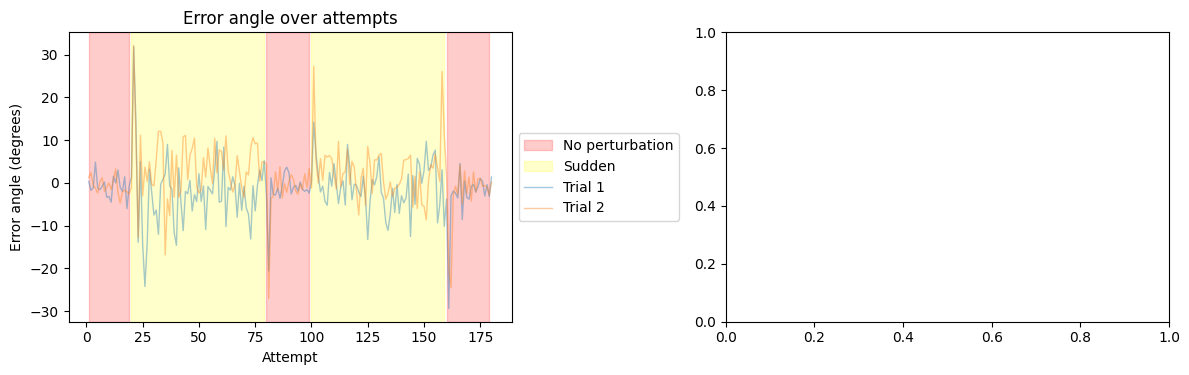

In [52]:
plot_error_angle(subject, experiment)

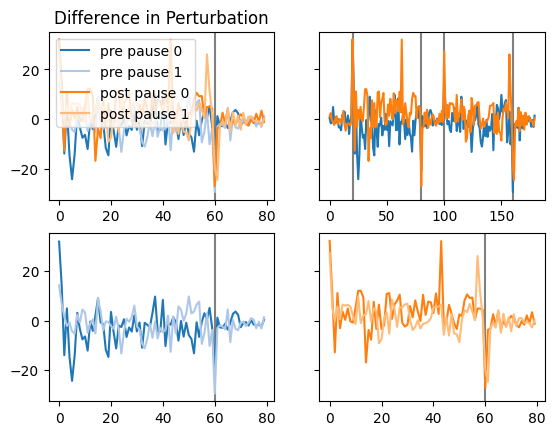

In [72]:
def _load_df(path: str) -> pd.DataFrame:
    content = np.load(path, allow_pickle=True).item()
    df = {
        "move_faster_logs": content["move_faster_logs"],
        "error_angle_logs": content["error_angle_logs"],
    }
    df = pd.DataFrame(df)
    df["attempt"] = np.arange(len(df))
    return df


def load_saving_data():
    data = []
    files = glob("*_savings_*.npy")
    pre_pause = list(filter(lambda x: x[-5] == "1", files))
    post_pause = [ele for ele in files if ele not in pre_pause]
    pre_pause = sorted(pre_pause)
    post_pause = sorted(post_pause)
    for idx, file in enumerate(pre_pause):
        df = _load_df(file)
        df["subject"] = idx
        df["pre_pose"] = True
        data.append(df)
    for idx, file in enumerate(post_pause):
        df = _load_df(file)
        df["subject"] = idx
        df["pre_pose"] = False
        data.append(df)

    df = pd.concat(data)
    return df


experiment = pd.DataFrame(
    {
        "Attempt": [1, 20, 80, 100, 160],
        "AttemptEnd": np.array([20, 80, 100, 160, 180]) - 1,
        "Perturbation": [
            "No perturbation",
            "Sudden",
            "No perturbation",
            "Sudden",
            "No perturbation",
        ],
    }
)

df = load_saving_data()

fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True)
cmap = mpl.colormaps["tab20"]


pre_pause = df[df["pre_pose"]]
post_pause = df[df["pre_pose"] == False]

ax = axs[0, 0]
ax.axvline(60, color="grey")
splits = np.split(pre_pause["error_angle_logs"].to_numpy(), [20, 100])
ax.plot(splits[1], color=cmap(0), label="pre pause 0")
ax.plot(splits[2], color=cmap(1), label="pre pause 1")

splits = np.split(post_pause["error_angle_logs"].to_numpy(), [20, 100])
ax.plot(splits[1], color=cmap(2), label="post pause 0")
ax.plot(splits[2], color=cmap(3), label="post pause 1")

ax.legend()
ax.set_title("Difference in Perturbation")

ax = axs[0, 1]
ax.axvline(20, color="grey")
ax.axvline(80, color="grey")
ax.axvline(100, color="grey")
ax.axvline(160, color="grey")
ax.plot(pre_pause["error_angle_logs"])
ax.plot(post_pause["error_angle_logs"])

ax = axs[1, 0]
ax.axvline(60, color="grey")
splits = np.split(pre_pause["error_angle_logs"].to_numpy(), [20, 100])
ax.plot(splits[1], color=cmap(0), label="pre pause 0")
ax.plot(splits[2], color=cmap(1), label="pre pause 1")


ax = axs[1, 1]
ax.axvline(60, color="grey")
splits = np.split(post_pause["error_angle_logs"].to_numpy(), [20, 100])
ax.plot(splits[1], color=cmap(2), label="post pause 0")
ax.plot(splits[2], color=cmap(3), label="post pause 1")
